<a href="https://colab.research.google.com/github/Gejalakshmi02/Amazon-scraper/blob/main/Credit_Card_Approval_Prediction_Using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading and exploring dataset...
File credit_card_data.csv not found. Using UCI Credit Card Approval dataset...
Dataset shape: (690, 16)

First 5 rows of the dataset:
  Gender    Age   Debt Married BankCustomer EducationLevel Ethnicity  \
0      b  30.83  0.000       u            g              w         v   
1      a  58.67  4.460       u            g              q         h   
2      a  24.50  0.500       u            g              q         h   
3      b  27.83  1.540       u            g              w         v   
4      b  20.17  5.625       u            g              w         v   

   YearsEmployed PriorDefault Employed  CreditScore DriversLicense Citizen  \
0           1.25            t        t            1              f       g   
1           3.04            t        t            6              f       g   
2           1.50            t        f            0              f       g   
3           3.75            t        t            5              t       g   
4         

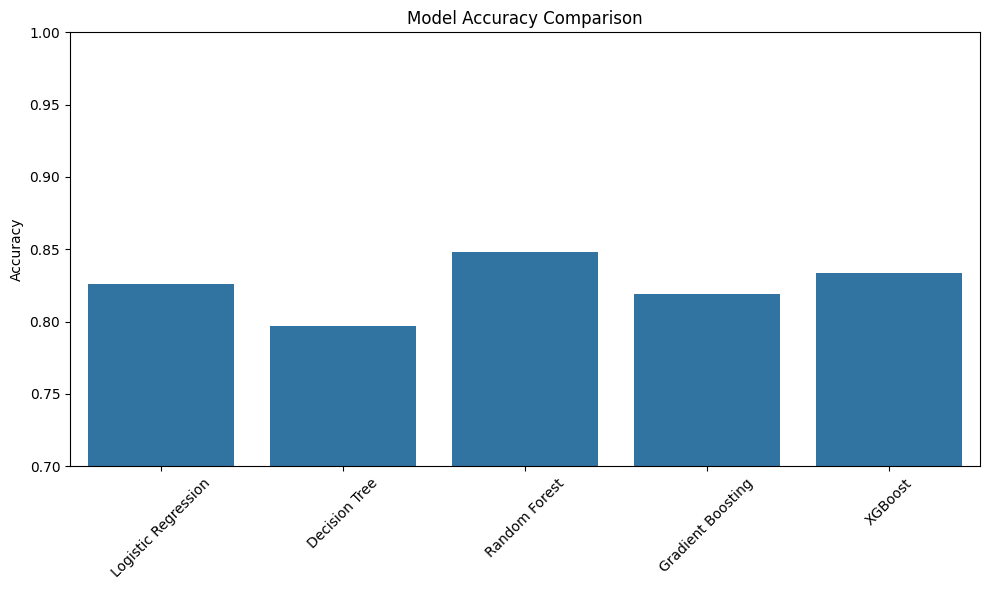

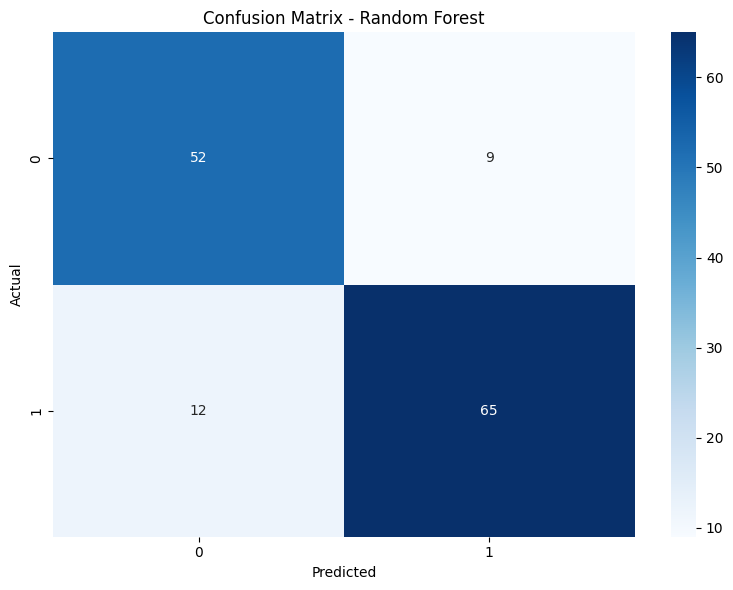

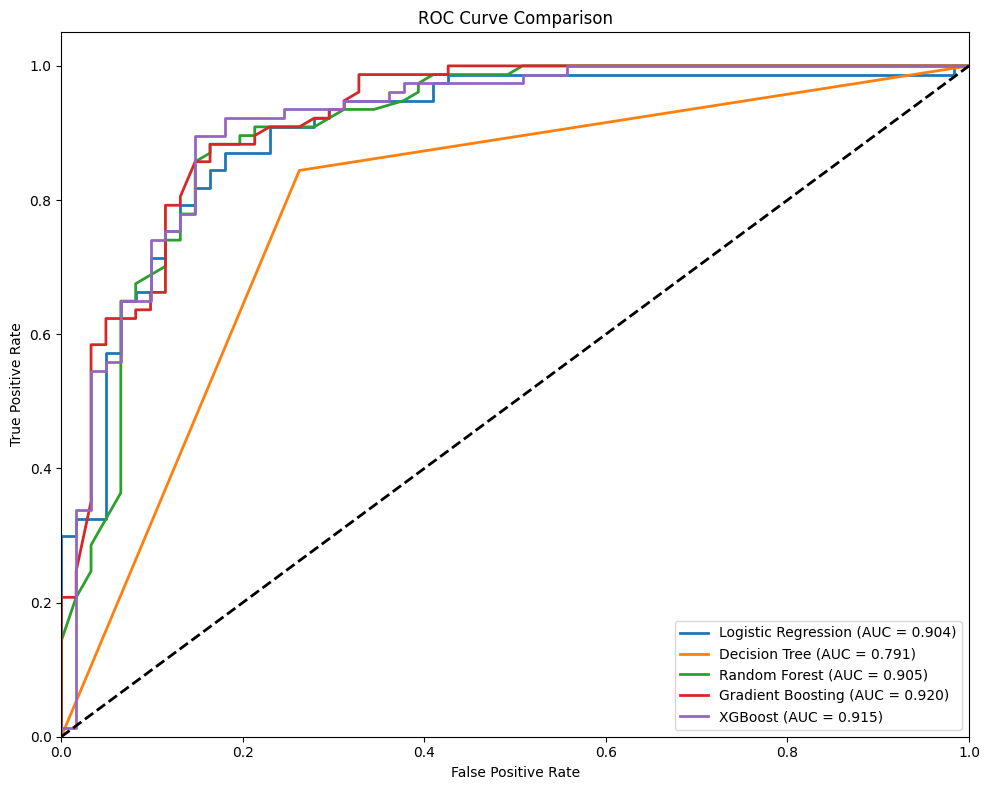

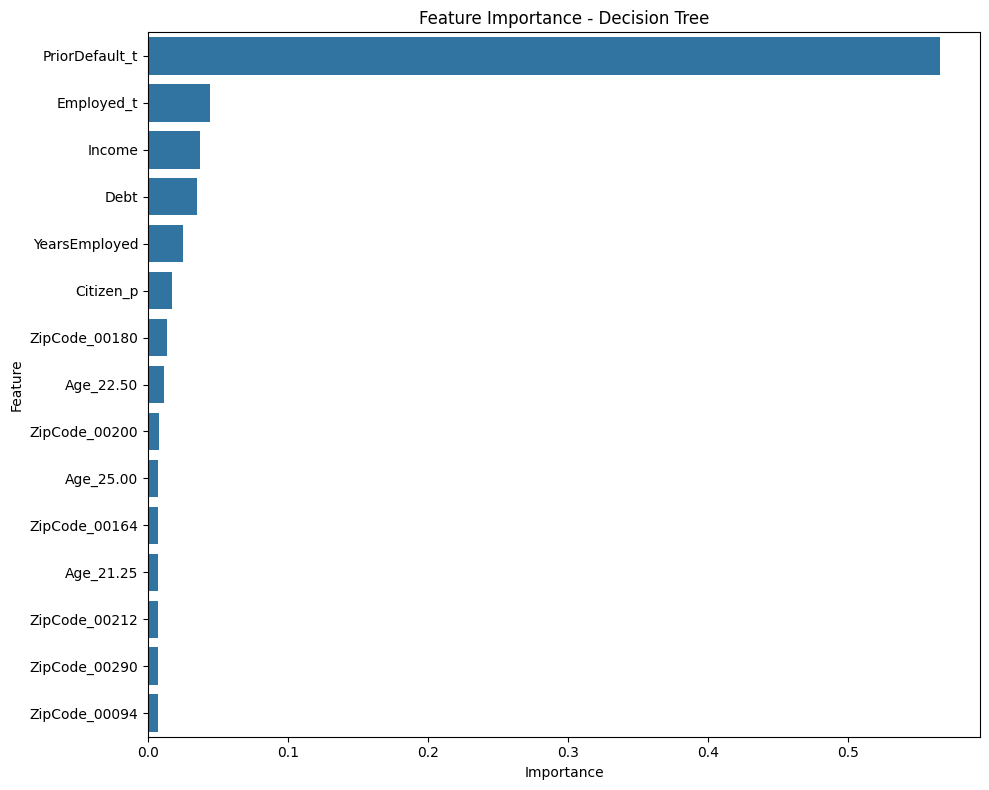

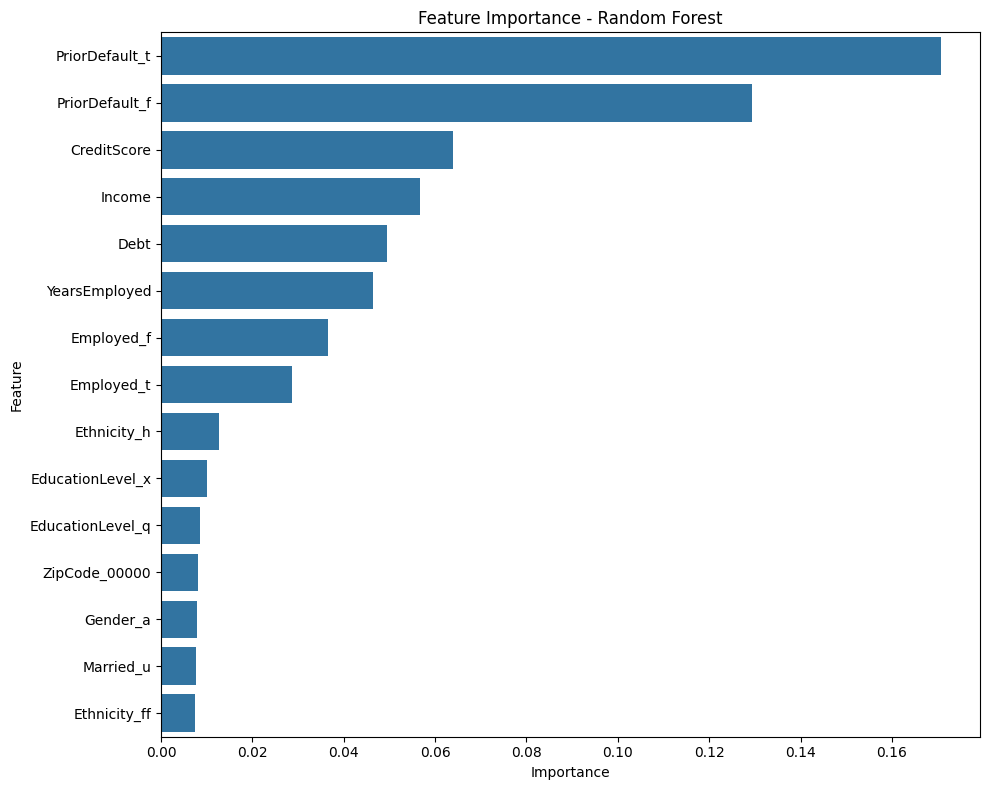

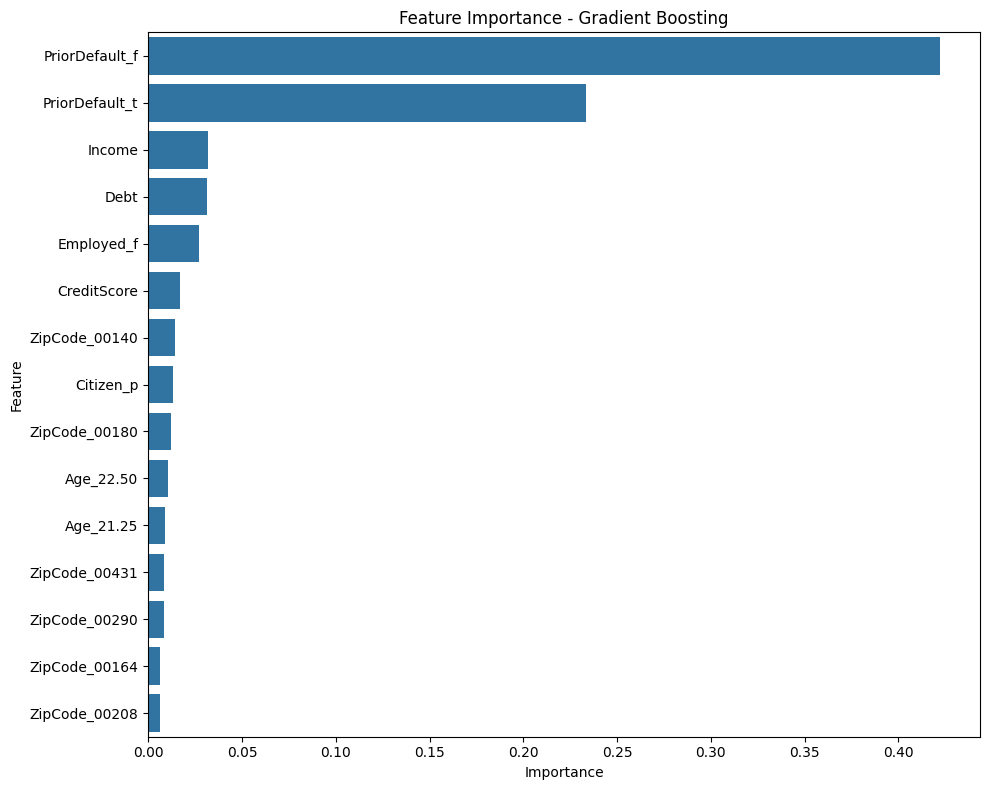

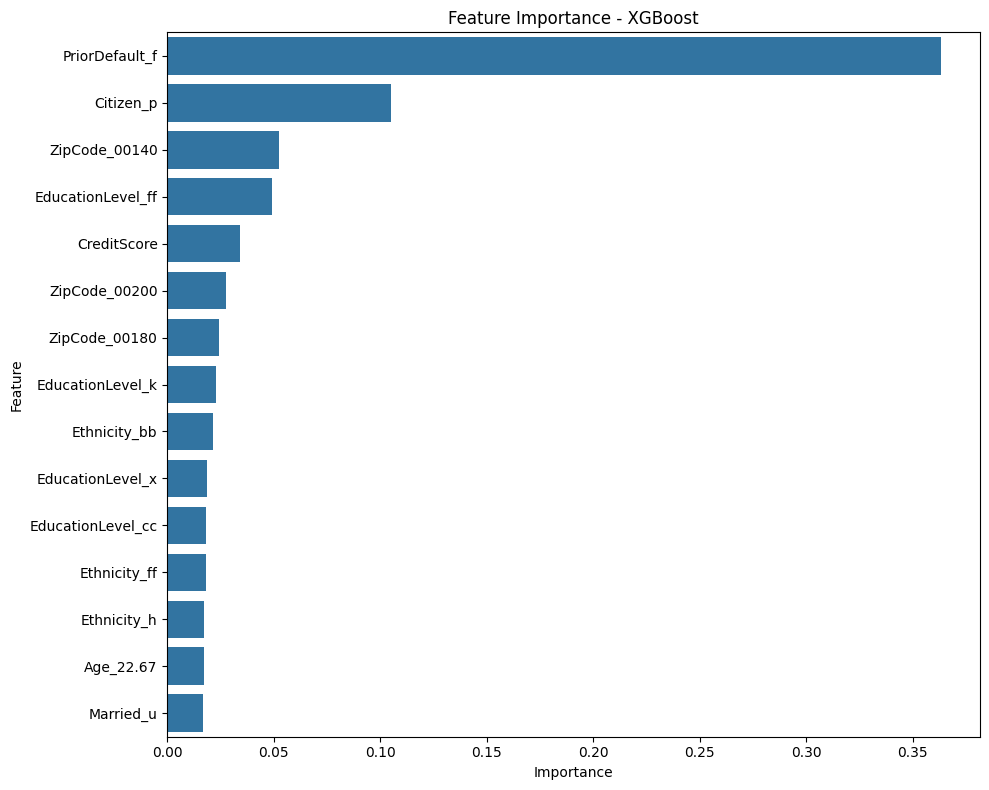


Performing fairness analysis...

Fairness analysis for Gender:
  Gender  size  accuracy  precision    recall  f1-score
0      b  96.0  0.833333   0.835417  0.833333  0.834008
1      a  37.0  0.891892   0.895081  0.891892  0.890745


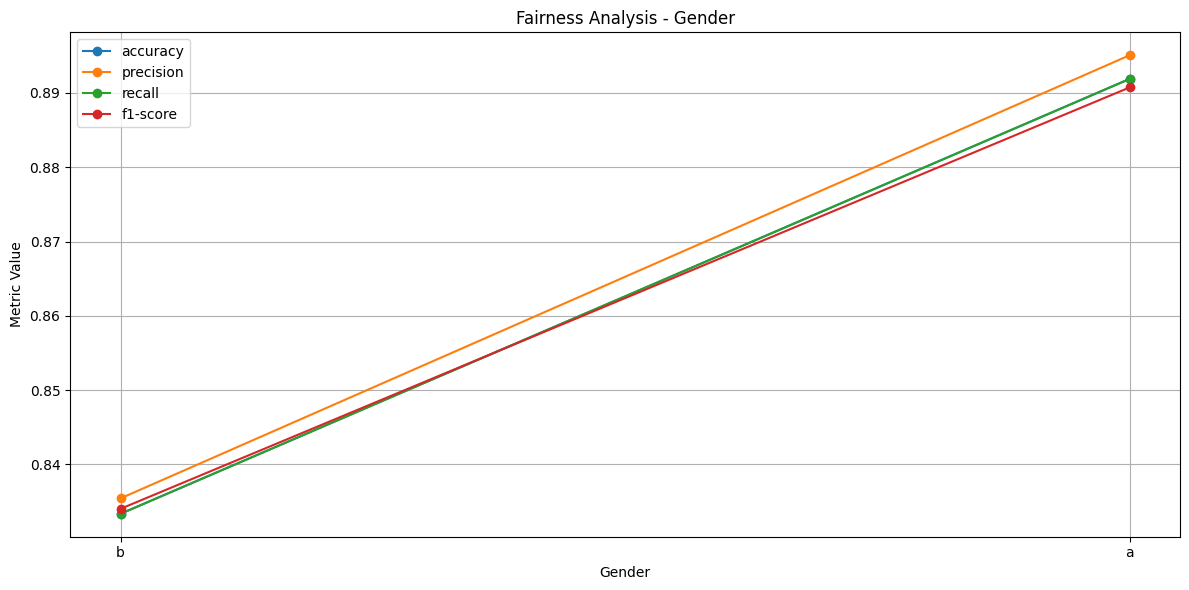


Fairness analysis for Age:
       Age  size  accuracy  precision  recall  f1-score
0    29.50   1.0       1.0        1.0     1.0       1.0
1    16.92   2.0       1.0        1.0     1.0       1.0
2    37.33   1.0       1.0        1.0     1.0       1.0
3    43.25   1.0       0.0        0.0     0.0       0.0
4    21.92   1.0       1.0        1.0     1.0       1.0
..     ...   ...       ...        ...     ...       ...
112  20.42   1.0       0.0        0.0     0.0       0.0
113  32.75   1.0       1.0        1.0     1.0       1.0
114  31.58   1.0       1.0        1.0     1.0       1.0
115  36.67   1.0       1.0        1.0     1.0       1.0
116  49.00   1.0       0.0        0.0     0.0       0.0

[117 rows x 6 columns]


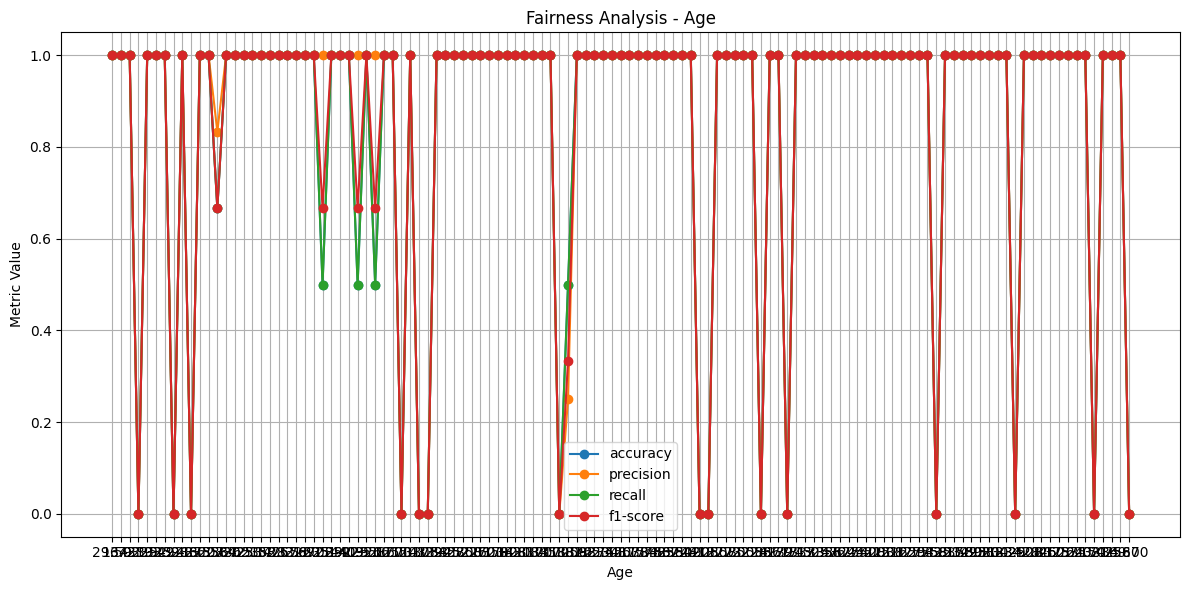


Interactive prediction mode...
Select Gender: ['Male', 'Female', 'Other']
Gender: female
Invalid input. Please choose from ['Male', 'Female', 'Other'].
Gender: Female
Enter Age: 20
Enter Debt: 1.5
Select Married: ['Single', 'Married', 'Divorced']
Married: Single
Select BankCustomer: ['Yes', 'No']
BankCustomer: Yes
Select EducationLevel: ['High School', 'Undergraduate', 'Graduate', 'PhD', 'Uneducated']
EducationLevel: Undergraduate
Select Ethnicity: ['White', 'Black', 'Asian', 'Hispanic', 'Other']
Ethnicity: Asian
Enter YearsEmployed: 5
Select PriorDefault: ['Yes', 'No']
PriorDefault: No
Select Employed: ['Yes', 'No']
Employed: Yes
Enter CreditScore: 540
Select DriversLicense: ['Yes', 'No']
DriversLicense: Yes
Select Citizen: ['Indian', 'Foreign', 'Others']
Citizen: Indian
Enter ZipCode: 606901
Enter Income: 5000

Prediction Result:
Approval Status: Approved
Confidence: 0.71


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

def load_and_explore_data(file_path):
    """
    Load and perform initial exploration of the credit card dataset
    """
    print("Loading and exploring dataset...")

    # For demonstration, we'll use the UCI Credit Card Approval dataset
    # If you have a specific file, replace this with your file path
    try:
        # Try loading from the provided path
        df = pd.read_csv(file_path)
    except:
        # Fallback to UCI dataset if file not found
        print(f"File {file_path} not found. Using UCI Credit Card Approval dataset...")
        df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data',
                        header=None)
        # Define column names based on UCI dataset documentation
        column_names = ['Gender', 'Age', 'Debt', 'Married', 'BankCustomer', 'EducationLevel',
                        'Ethnicity', 'YearsEmployed', 'PriorDefault', 'Employed', 'CreditScore',
                        'DriversLicense', 'Citizen', 'ZipCode', 'Income', 'Approved']
        df.columns = column_names

        # Convert '?' to NaN for proper handling of missing values
        df = df.replace('?', np.nan)

    # Display basic dataset information
    print(f"Dataset shape: {df.shape}")
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    print("\nData summary:")
    print(df.describe())
    print("\nMissing values:")
    print(df.isnull().sum())

    return df

def preprocess_data(df):
    """
    Preprocess the dataset - handle missing values, encode categorical variables, and scale numerical features
    """
    print("\nPreprocessing data...")

    # Make a copy to avoid modifying the original dataframe
    data = df.copy()

    # Identify the target variable (assuming it's in the last column)
    target_column = data.columns[-1]

    # Convert target to binary if it's not already (e.g., 'Approved' to 0/1)
    if data[target_column].dtype == 'object':
        label_encoder = LabelEncoder()
        data[target_column] = label_encoder.fit_transform(data[target_column].astype(str))
        print(f"Target classes: {label_encoder.classes_}, encoded as: {np.unique(data[target_column])}")

    # Separate features and target
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Identify numerical and categorical columns
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    print(f"Numerical features: {list(numeric_features)}")
    print(f"Categorical features: {list(categorical_features)}")

    # Create preprocessing pipelines
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")

    return X_train, X_test, y_train, y_test, preprocessor

def handle_imbalanced_data(X_train, y_train):
    """
    Handle imbalanced classes using SMOTE
    """
    print("\nChecking for class imbalance...")
    class_counts = pd.Series(y_train).value_counts()
    print(f"Class distribution: {class_counts}")

    # Calculate imbalance ratio
    imbalance_ratio = class_counts.max() / class_counts.min()
    print(f"Imbalance ratio: {imbalance_ratio:.2f}")

    # Apply SMOTE if there's significant imbalance (ratio > 1.5)
    if imbalance_ratio > 1.5:
        print("Applying SMOTE to handle class imbalance...")
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        print(f"Shape after SMOTE: {X_train_resampled.shape}")
        print(f"New class distribution: {pd.Series(y_train_resampled).value_counts()}")
        return X_train_resampled, y_train_resampled
    else:
        print("Class distribution is relatively balanced. Skipping SMOTE.")
        return X_train, y_train

def train_and_evaluate_models(X_train, X_test, y_train, y_test, preprocessor):
    """
    Train multiple models, evaluate their performance, and return the best model
    """
    print("\nTraining and evaluating models...")

    # Define models to train
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42)
    }

    # Create preprocessing and model pipeline
    results = {}
    best_score = 0
    best_model_name = None

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Create pipeline with preprocessing and model
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        # Train the model
        pipeline.fit(X_train, y_train)

        # Make predictions
        y_pred = pipeline.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = {
            'pipeline': pipeline,
            'accuracy': accuracy,
            'classification_report': classification_report(y_test, y_pred, output_dict=True)
        }

        print(f"{name} Accuracy: {accuracy:.4f}")
        print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

        # Update best model if current one is better
        if accuracy > best_score:
            best_score = accuracy
            best_model_name = name

    print(f"\nBest model: {best_model_name} with accuracy: {best_score:.4f}")

    # Return all results and the best model
    return results, results[best_model_name]['pipeline']

def visualize_results(results, X_test, y_test):
    """
    Create visualizations for model comparison and feature importance
    """
    print("\nVisualizing results...")

    # Model accuracy comparison
    model_names = list(results.keys())
    accuracy_scores = [results[name]['accuracy'] for name in model_names]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=model_names, y=accuracy_scores)
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0.7, 1.0)  # Adjust as needed
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('model_accuracy_comparison.png')
    plt.show()

    # Confusion Matrix for the best model
    best_model_name = max(results, key=lambda x: results[x]['accuracy'])
    best_pipeline = results[best_model_name]['pipeline']

    y_pred = best_pipeline.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    # ROC Curve for all models
    plt.figure(figsize=(10, 8))

    for name in results:
        pipeline = results[name]['pipeline']
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig('roc_curve_comparison.png')
    plt.show()

    # Feature importance for tree-based models
    tree_models = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']
    for model_name in tree_models:
        if model_name in results:
            try:
                # Extract feature names after preprocessing
                preprocessor = results[model_name]['pipeline'].named_steps['preprocessor']
                model = results[model_name]['pipeline'].named_steps['classifier']

                # For tree models that have feature_importances_
                if hasattr(model, 'feature_importances_'):
                    # Get feature names from the preprocessor
                    feature_names = []
                    for name, transformer, cols in preprocessor.transformers_:
                        if name != 'remainder':
                            if hasattr(transformer, 'get_feature_names_out'):
                                transformed_names = transformer.get_feature_names_out(cols)
                                feature_names.extend(transformed_names)
                            else:
                                # Fallback if get_feature_names_out not available
                                feature_names.extend([f"{name}_{col}" for col in cols])

                    # Get feature importances
                    importances = model.feature_importances_

                    # Create dataframe with feature names and importances
                    if len(feature_names) == len(importances):
                        feature_imp = pd.DataFrame({
                            'Feature': feature_names,
                            'Importance': importances
                        }).sort_values(by='Importance', ascending=False)

                        # Plot top 15 features or all if fewer
                        n_features = min(15, len(feature_imp))
                        plt.figure(figsize=(10, 8))
                        sns.barplot(x='Importance', y='Feature', data=feature_imp.head(n_features))
                        plt.title(f'Feature Importance - {model_name}')
                        plt.tight_layout()
                        plt.savefig(f'feature_importance_{model_name.replace(" ", "_").lower()}.png')
                        plt.show()
            except Exception as e:
                print(f"Couldn't plot feature importance for {model_name}: {e}")

def fairness_analysis(best_model, X_test, y_test, sensitive_attributes):
    """
    Analyze model fairness across different demographic groups

    Args:
        best_model: The trained pipeline (preprocessor + model)
        X_test: Test features
        y_test: True labels
        sensitive_attributes: Dictionary mapping column indices to sensitive attribute names
    """
    print("\nPerforming fairness analysis...")

    try:
        # Clone X_test to avoid modifications
        X_test_copy = X_test.copy()

        # Get predictions
        y_pred = best_model.predict(X_test_copy)

        # For each sensitive attribute
        for col_idx, attr_name in sensitive_attributes.items():
            if col_idx < X_test_copy.shape[1]:
                # Get unique values of the sensitive attribute
                unique_values = X_test_copy.iloc[:, col_idx].unique()

                print(f"\nFairness analysis for {attr_name}:")
                metrics_by_group = {}

                # Calculate metrics for each group
                for value in unique_values:
                    # Filter test data by group
                    group_indices = X_test_copy.iloc[:, col_idx] == value
                    group_y_test = y_test[group_indices]
                    group_y_pred = y_pred[group_indices]

                    if len(group_y_test) > 0:
                        # Calculate metrics
                        accuracy = accuracy_score(group_y_test, group_y_pred)
                        report = classification_report(group_y_test, group_y_pred, output_dict=True)

                        metrics_by_group[value] = {
                            'size': len(group_y_test),
                            'accuracy': accuracy,
                            'precision': report['weighted avg']['precision'],
                            'recall': report['weighted avg']['recall'],
                            'f1-score': report['weighted avg']['f1-score']
                        }

                # Create a DataFrame for easier comparison
                fairness_df = pd.DataFrame(metrics_by_group).T
                fairness_df.index.name = attr_name
                fairness_df = fairness_df.reset_index()

                print(fairness_df)

                # Visualize fairness metrics
                plt.figure(figsize=(12, 6))
                metrics = ['accuracy', 'precision', 'recall', 'f1-score']

                for metric in metrics:
                    plt.plot(fairness_df[attr_name], fairness_df[metric], label=metric, marker='o')

                plt.title(f'Fairness Analysis - {attr_name}')
                plt.xlabel(attr_name)
                plt.ylabel('Metric Value')
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.savefig(f'fairness_analysis_{attr_name.replace(" ", "_").lower()}.png')
                plt.show()

    except Exception as e:
        print(f"Error during fairness analysis: {e}")

def interactive_prediction(best_model):
    """
    Allow users to input applicant details and get a credit card approval prediction.
    Inputs are now more user-friendly and aligned with real-world scenarios.
    """
    print("\nInteractive prediction mode...")

    # Define user-friendly input fields
    input_fields = {
        'Gender': ['Male', 'Female','Other'],
        'Age': 'numeric',
        'Debt': 'numeric',
        'Married': ['Single', 'Married', 'Divorced'],
        'BankCustomer': ['Yes', 'No'],
        'EducationLevel': ['High School', 'Undergraduate', 'Graduate', 'PhD','Uneducated'],
        'Ethnicity': ['White', 'Black', 'Asian', 'Hispanic', 'Other'],
        'YearsEmployed': 'numeric',
        'PriorDefault': ['Yes', 'No'],
        'Employed': ['Yes', 'No'],
        'CreditScore': 'numeric',
        'DriversLicense': ['Yes', 'No'],
        'Citizen': ['Indian', 'Foreign','Others'],
        'ZipCode': 'numeric',
        'Income': 'numeric',
    }

    # Collect user input
    user_input = {}
    for field, options in input_fields.items():
        if isinstance(options, list):  # Categorical field
            print(f"Select {field}: {options}")
            value = input(f"{field}: ").strip()
            while value not in options:
                print(f"Invalid input. Please choose from {options}.")
                value = input(f"{field}: ").strip()
            user_input[field] = value
        else:  # Numeric field
            value = input(f"Enter {field}: ").strip()
            while not value.replace('.', '').isdigit():
                print(f"Invalid input. Please enter a numeric value.")
                value = input(f"Enter {field}: ").strip()
            user_input[field] = float(value)

    # Map user-friendly inputs to model-friendly format
    input_mapping = {
        'Gender': {'Male': 'a', 'Female': 'b',  'Other': 'o'},
        'Married': {'Single': 'u', 'Married': 'y', 'Divorced': 'l'},
        'BankCustomer': {'Yes': 'g', 'No': 'p'},
        'EducationLevel': {
            'High School': 'c', 'Undergraduate': 'd', 'Graduate': 'm', 'PhD': 'e', 'Uneducated': 'oo'
        },
        'Ethnicity': {
            'White': 'v', 'Black': 'h', 'Asian': 'bb', 'Hispanic': 'j', 'Other': 'o'
        },
        'PriorDefault': {'Yes': 't', 'No': 'f'},
        'Employed': {'Yes': 't', 'No': 'f'},
        'DriversLicense': {'Yes': 't', 'No': 'f'},
        'Citizen': {'Indian': 'g', 'Foreign': 's','Others':'o'},
    }

    # Convert user-friendly inputs to model-friendly format
    model_input = {}
    for field, value in user_input.items():
        if field in input_mapping:
            model_input[field] = input_mapping[field][value]
        else:
            model_input[field] = value

    # Convert input to DataFrame
    input_df = pd.DataFrame([model_input])

    # Make prediction
    prediction = best_model.predict(input_df)
    prediction_proba = best_model.predict_proba(input_df)

    # Display result
    print("\nPrediction Result:")
    print(f"Approval Status: {'Approved' if prediction[0] == 1 else 'Not Approved'}")
    print(f"Confidence: {prediction_proba[0][prediction[0]]:.2f}")

def main():
    """
    Main function to execute the credit card approval prediction system
    """
    # Load and explore data
    file_path = 'credit_card_data.csv'  # Replace with your dataset path
    df = load_and_explore_data(file_path)

    # Preprocess data
    X_train, X_test, y_train, y_test, preprocessor = preprocess_data(df)

    # Handle imbalanced data
    X_train_resampled, y_train_resampled = handle_imbalanced_data(X_train, y_train)

    # Train and evaluate models
    results, best_model = train_and_evaluate_models(X_train_resampled, X_test, y_train_resampled, y_test, preprocessor)

    # Visualize results
    visualize_results(results, X_test, y_test)

    # Fairness analysis (define sensitive attributes)
    sensitive_attributes = {0: 'Gender', 1: 'Age'}  # Adjust based on dataset
    fairness_analysis(best_model, X_test, y_test, sensitive_attributes)

    # Interactive prediction
    interactive_prediction(best_model)


if __name__ == "__main__":
    main()